Files already downloaded and verified


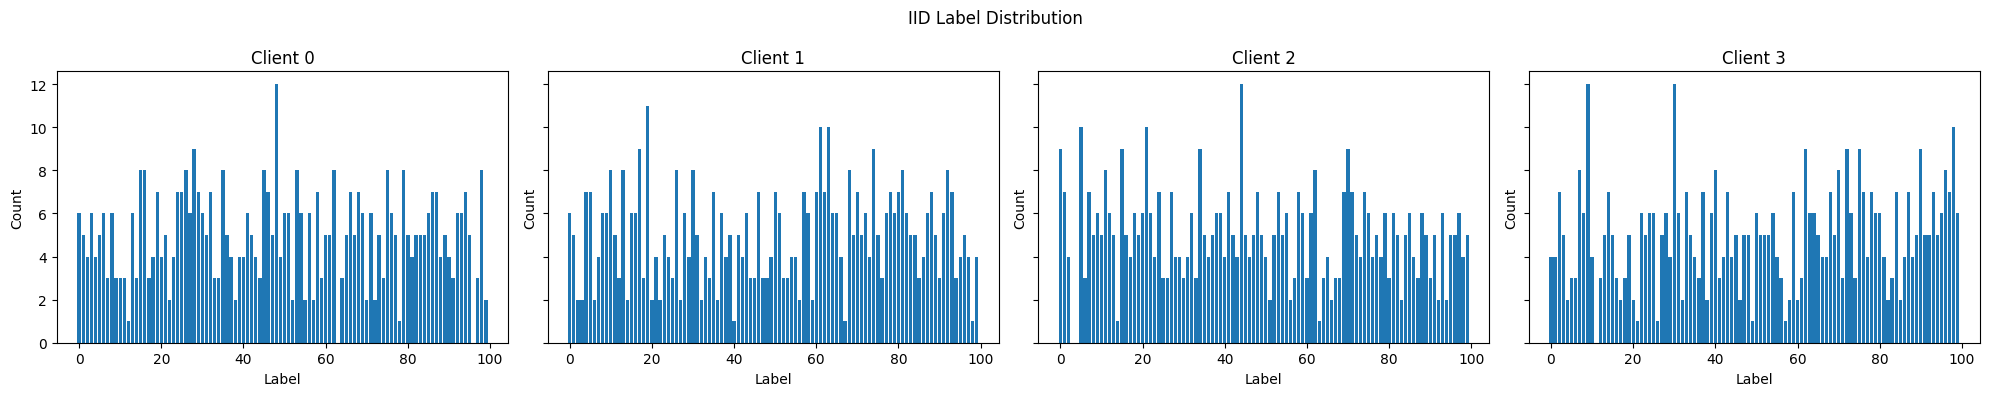

[Non-IID] samples_per_client: 500
[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 156.52it/s]


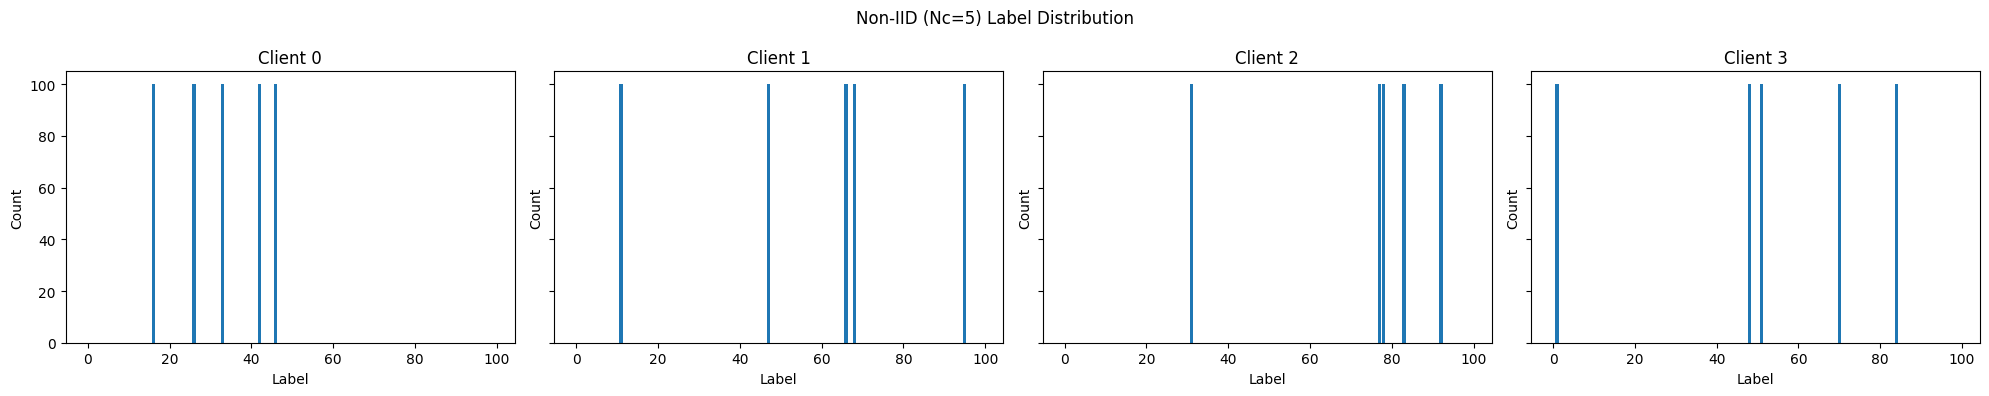

In [1]:
import torch
import pandas as pd
import numpy as np
import random
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

class DatasetSharder:
    """
    Creates IID or Non-IID shards for a dataset.
    Non-IID logic is adapted from your snippet:
      - Sort the dataset by label (for clarity).
      - Use a DataFrame to manage the data.
      - Each client c picks n_labels at random from what's left,
        samples ~samples_per_label from each label, and removes them from the global pool.
      - Some label overlap across clients can happen (since each client picks from the
        remaining labels randomly).
    """

    def __init__(self, dataset, K, shard_type='iid', n_labels=5):
        """
        Args:
            dataset: A PyTorch dataset (e.g. torchvision.datasets.CIFAR100)
            K: Number of clients
            shard_type: 'iid' or 'non_iid'
            n_labels: For non-iid, how many labels each client should pick
        """
        self.dataset = dataset
        self.K = K
        self.shard_type = shard_type
        self.n_labels = n_labels

    def shard_dataset(self):
        """
        Main entry point. Returns a list of K Subset objects, one for each client.
        """
        if self.shard_type == 'iid':
            return self.iid_split()
        elif self.shard_type == 'non_iid':
            return self.non_iid_split()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

    def iid_split(self):
        """
        IID partition:
          - Randomly splits the dataset into K roughly equal parts.
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K

        # Distribute remainder if not perfectly divisible
        lengths = [samples_per_client] * self.K
        remainder = dataset_size - (samples_per_client * self.K)
        for i in range(remainder):
            lengths[i] += 1

        subsets = random_split(self.dataset, lengths)
        return list(subsets)

    def non_iid_split(self):
        """
        Non-IID partition adapted from your snippet:
          - Sort the dataset by label, store in a DataFrame.
          - For each client c:
             1) Randomly picks self.n_labels from the unique labels in the leftover data
             2) For each chosen label, sample ~samples_per_label from that label
             3) Remove those samples from the global DataFrame
          - Allows label overlap across clients if the random choice repeats a label
            (and if there's still leftover samples for that label).
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K
        print(f"[Non-IID] samples_per_client: {samples_per_client}")

        # Build list of (original_index, (image, label))
        enumerated_data = list(enumerate(self.dataset))
        # Sort by label => enumerated_data[i][1][1] is the label
        enumerated_data.sort(key=lambda x: x[1][1])

        # Convert to DataFrame: columns=[orig_idx, img, targets]
        rows = []
        for (orig_idx, (img, label)) in enumerated_data:
            rows.append((orig_idx, img, label))
        df = pd.DataFrame(rows, columns=["orig_idx", "img", "targets"])

        # ~samples per label for each client
        samples_per_label = samples_per_client // self.n_labels
        print(f"[Non-IID] samples_per_label: {samples_per_label}")

        # If we can't even assign 1 sample per label, raise an error (or handle differently)
        if samples_per_label < 1:
            raise ValueError(
                f"non_iid_split: samples_per_label={samples_per_label} < 1.\n"
                "K or n_labels might be too large for the dataset size."
            )

        clients_subsets = []

        for c in tqdm(range(self.K), desc="Non-IID Splitting"):
            client_rows = []
            # All unique labels left in df
            available_labels = list(df["targets"].unique())
            # Shuffle them and pick n_labels
            np.random.shuffle(available_labels)
            chosen_labels = available_labels[:self.n_labels]

            for label in chosen_labels:
                label_data = df[df["targets"] == label]

                if len(label_data) >= samples_per_label:
                    sampled = label_data.sample(samples_per_label)
                    client_rows.extend(sampled.values.tolist())
                    df = df.drop(sampled.index)

                    # If leftover < samples_per_label, take them all
                    leftover_label_data = df[df["targets"] == label]
                    if len(leftover_label_data) < samples_per_label:
                        client_rows.extend(leftover_label_data.values.tolist())
                        df = df.drop(leftover_label_data.index)
                else:
                    # Not enough data for this label => take it all
                    client_rows.extend(label_data.values.tolist())
                    df = df.drop(label_data.index)

            # Build a Subset from these rows
            client_indices = [row[0] for row in client_rows]  # first column is orig_idx
            subset_for_client = Subset(self.dataset, client_indices)
            clients_subsets.append(subset_for_client)

        return clients_subsets

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=4):
    """
    Plots the label distribution for up to `max_clients_to_plot` clients.
    Each 'client_datasets[i]' is a Subset of the original dataset.
    """
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)
    fig, axes = plt.subplots(1, num_clients_to_plot, figsize=(5 * num_clients_to_plot, 4), sharey=True)
    if num_clients_to_plot == 1:
        axes = [axes]

    for i in range(num_clients_to_plot):
        subset_indices = client_datasets[i].indices
        # Gather labels
        labels = [client_datasets[i].dataset[idx][1] for idx in subset_indices]
        label_counts = [0]*num_classes
        for lab in labels:
            label_counts[lab] += 1

        axes[i].bar(range(num_classes), label_counts)
        axes[i].set_title(f"Client {i}")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("Count")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main():
    # Example: Let's use K=4 just for a quick demonstration
    # (You can set K=100 if you wish, but plotting distribution for 100 clients can be large)
    K = 100
    n_labels = 5  # for non-iid

    # Fix seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Load CIFAR-100 (train set)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])
    trainset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

    # --------------------------------------------------------------------
    # 1. IID Sharding
    # --------------------------------------------------------------------
    iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='iid')
    iid_client_datasets = iid_sharder.shard_dataset()

    # Plot IID distribution for the first few clients
    plot_label_distribution(
        iid_client_datasets,
        num_classes=100,
        title="IID Label Distribution",
        max_clients_to_plot=4
    )

    # --------------------------------------------------------------------
    # 2. Non-IID Sharding
    # --------------------------------------------------------------------
    non_iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='non_iid', n_labels=n_labels)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()

    # Plot Non-IID distribution for the first few clients
    plot_label_distribution(
        non_iid_client_datasets,
        num_classes=100,
        title=f"Non-IID (Nc={n_labels}) Label Distribution",
        max_clients_to_plot=4
    )

if __name__ == "__main__":
    main()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Shard config: iid ---


Federated Training Rounds:   0%|          | 1/1000 [00:06<1:46:52,  6.42s/it]

Round 1 => Test Accuracy: 1.81%


Federated Training Rounds:   1%|          | 10/1000 [00:52<1:26:44,  5.26s/it]

Round 10 => Test Accuracy: 9.82%


Federated Training Rounds:   2%|▏         | 20/1000 [01:43<1:29:28,  5.48s/it]

Round 20 => Test Accuracy: 14.50%


Federated Training Rounds:   3%|▎         | 30/1000 [02:36<1:29:00,  5.51s/it]

Round 30 => Test Accuracy: 19.07%


Federated Training Rounds:   4%|▍         | 40/1000 [03:29<1:28:58,  5.56s/it]

Round 40 => Test Accuracy: 22.45%


Federated Training Rounds:   5%|▌         | 50/1000 [04:22<1:26:19,  5.45s/it]

Round 50 => Test Accuracy: 25.25%


Federated Training Rounds:   6%|▌         | 60/1000 [05:14<1:25:56,  5.49s/it]

Round 60 => Test Accuracy: 27.99%


Federated Training Rounds:   7%|▋         | 70/1000 [06:06<1:24:19,  5.44s/it]

Round 70 => Test Accuracy: 29.57%


Federated Training Rounds:   8%|▊         | 80/1000 [06:59<1:24:16,  5.50s/it]

Round 80 => Test Accuracy: 31.74%


Federated Training Rounds:   9%|▉         | 90/1000 [07:51<1:23:14,  5.49s/it]

Round 90 => Test Accuracy: 33.45%


Federated Training Rounds:  10%|█         | 100/1000 [08:43<1:21:10,  5.41s/it]

Round 100 => Test Accuracy: 33.70%


Federated Training Rounds:  11%|█         | 110/1000 [09:35<1:18:55,  5.32s/it]

Round 110 => Test Accuracy: 35.09%


Federated Training Rounds:  12%|█▏        | 120/1000 [10:26<1:17:40,  5.30s/it]

Round 120 => Test Accuracy: 36.27%


Federated Training Rounds:  13%|█▎        | 130/1000 [11:19<1:19:14,  5.47s/it]

Round 130 => Test Accuracy: 36.39%


Federated Training Rounds:  14%|█▍        | 140/1000 [12:11<1:18:15,  5.46s/it]

Round 140 => Test Accuracy: 37.68%


Federated Training Rounds:  15%|█▌        | 150/1000 [13:03<1:16:40,  5.41s/it]

Round 150 => Test Accuracy: 38.40%


Federated Training Rounds:  16%|█▌        | 160/1000 [13:55<1:16:17,  5.45s/it]

Round 160 => Test Accuracy: 39.10%


Federated Training Rounds:  17%|█▋        | 170/1000 [14:47<1:14:10,  5.36s/it]

Round 170 => Test Accuracy: 39.72%


Federated Training Rounds:  18%|█▊        | 180/1000 [15:39<1:14:10,  5.43s/it]

Round 180 => Test Accuracy: 40.58%


Federated Training Rounds:  19%|█▉        | 190/1000 [16:31<1:13:39,  5.46s/it]

Round 190 => Test Accuracy: 41.32%


Federated Training Rounds:  20%|██        | 200/1000 [17:24<1:11:44,  5.38s/it]

Round 200 => Test Accuracy: 41.30%


Federated Training Rounds:  21%|██        | 210/1000 [18:15<1:10:45,  5.37s/it]

Round 210 => Test Accuracy: 42.15%


Federated Training Rounds:  22%|██▏       | 220/1000 [19:07<1:09:18,  5.33s/it]

Round 220 => Test Accuracy: 42.76%


Federated Training Rounds:  23%|██▎       | 230/1000 [19:59<1:09:10,  5.39s/it]

Round 230 => Test Accuracy: 43.33%


Federated Training Rounds:  24%|██▍       | 240/1000 [20:51<1:08:31,  5.41s/it]

Round 240 => Test Accuracy: 43.21%


Federated Training Rounds:  25%|██▌       | 250/1000 [21:43<1:07:18,  5.38s/it]

Round 250 => Test Accuracy: 44.13%


Federated Training Rounds:  26%|██▌       | 260/1000 [22:35<1:05:08,  5.28s/it]

Round 260 => Test Accuracy: 44.71%


Federated Training Rounds:  27%|██▋       | 270/1000 [23:27<1:06:05,  5.43s/it]

Round 270 => Test Accuracy: 44.30%


Federated Training Rounds:  28%|██▊       | 280/1000 [24:18<1:04:11,  5.35s/it]

Round 280 => Test Accuracy: 45.55%


Federated Training Rounds:  29%|██▉       | 290/1000 [25:10<1:02:37,  5.29s/it]

Round 290 => Test Accuracy: 45.44%


Federated Training Rounds:  30%|███       | 300/1000 [26:02<1:03:46,  5.47s/it]

Round 300 => Test Accuracy: 46.74%


Federated Training Rounds:  31%|███       | 310/1000 [26:54<1:02:12,  5.41s/it]

Round 310 => Test Accuracy: 45.90%


Federated Training Rounds:  32%|███▏      | 320/1000 [27:46<1:00:14,  5.32s/it]

Round 320 => Test Accuracy: 47.07%


Federated Training Rounds:  33%|███▎      | 330/1000 [28:38<1:00:56,  5.46s/it]

Round 330 => Test Accuracy: 46.51%


Federated Training Rounds:  34%|███▍      | 340/1000 [29:31<59:47,  5.44s/it]  

Round 340 => Test Accuracy: 47.58%


Federated Training Rounds:  35%|███▌      | 350/1000 [30:23<57:55,  5.35s/it]

Round 350 => Test Accuracy: 47.96%


Federated Training Rounds:  36%|███▌      | 360/1000 [31:14<57:16,  5.37s/it]

Round 360 => Test Accuracy: 48.27%


Federated Training Rounds:  37%|███▋      | 370/1000 [32:05<56:14,  5.36s/it]

Round 370 => Test Accuracy: 48.24%


Federated Training Rounds:  38%|███▊      | 380/1000 [32:57<55:12,  5.34s/it]

Round 380 => Test Accuracy: 48.35%


Federated Training Rounds:  39%|███▉      | 390/1000 [33:49<54:48,  5.39s/it]

Round 390 => Test Accuracy: 48.57%


Federated Training Rounds:  40%|████      | 400/1000 [34:41<54:41,  5.47s/it]

Round 400 => Test Accuracy: 48.81%


Federated Training Rounds:  41%|████      | 410/1000 [35:33<52:40,  5.36s/it]

Round 410 => Test Accuracy: 49.43%


Federated Training Rounds:  42%|████▏     | 420/1000 [36:24<51:06,  5.29s/it]

Round 420 => Test Accuracy: 49.68%


Federated Training Rounds:  43%|████▎     | 430/1000 [37:16<51:16,  5.40s/it]

Round 430 => Test Accuracy: 49.51%


Federated Training Rounds:  44%|████▍     | 440/1000 [38:07<50:14,  5.38s/it]

Round 440 => Test Accuracy: 49.83%


Federated Training Rounds:  45%|████▌     | 450/1000 [39:00<49:57,  5.45s/it]

Round 450 => Test Accuracy: 50.27%


Federated Training Rounds:  46%|████▌     | 460/1000 [39:52<48:08,  5.35s/it]

Round 460 => Test Accuracy: 50.03%


Federated Training Rounds:  47%|████▋     | 470/1000 [40:44<48:26,  5.48s/it]

Round 470 => Test Accuracy: 50.16%


Federated Training Rounds:  48%|████▊     | 480/1000 [41:35<45:40,  5.27s/it]

Round 480 => Test Accuracy: 50.51%


Federated Training Rounds:  49%|████▉     | 490/1000 [42:27<46:08,  5.43s/it]

Round 490 => Test Accuracy: 50.40%


Federated Training Rounds:  50%|█████     | 500/1000 [43:18<44:05,  5.29s/it]

Round 500 => Test Accuracy: 50.37%


Federated Training Rounds:  51%|█████     | 510/1000 [44:10<43:58,  5.38s/it]

Round 510 => Test Accuracy: 50.99%


Federated Training Rounds:  52%|█████▏    | 520/1000 [45:01<42:14,  5.28s/it]

Round 520 => Test Accuracy: 51.50%


Federated Training Rounds:  53%|█████▎    | 530/1000 [45:52<41:53,  5.35s/it]

Round 530 => Test Accuracy: 51.34%


Federated Training Rounds:  54%|█████▍    | 540/1000 [46:45<41:29,  5.41s/it]

Round 540 => Test Accuracy: 50.81%


Federated Training Rounds:  55%|█████▌    | 550/1000 [47:36<40:01,  5.34s/it]

Round 550 => Test Accuracy: 51.32%


Federated Training Rounds:  56%|█████▌    | 560/1000 [48:27<39:28,  5.38s/it]

Round 560 => Test Accuracy: 51.36%


Federated Training Rounds:  57%|█████▋    | 570/1000 [49:19<38:39,  5.39s/it]

Round 570 => Test Accuracy: 51.46%


Federated Training Rounds:  58%|█████▊    | 580/1000 [50:10<37:30,  5.36s/it]

Round 580 => Test Accuracy: 51.48%


Federated Training Rounds:  59%|█████▉    | 590/1000 [51:02<36:27,  5.34s/it]

Round 590 => Test Accuracy: 52.25%


Federated Training Rounds:  60%|██████    | 600/1000 [51:53<35:38,  5.35s/it]

Round 600 => Test Accuracy: 51.82%


Federated Training Rounds:  61%|██████    | 610/1000 [52:45<34:24,  5.29s/it]

Round 610 => Test Accuracy: 52.15%


Federated Training Rounds:  62%|██████▏   | 620/1000 [53:36<33:40,  5.32s/it]

Round 620 => Test Accuracy: 52.32%


Federated Training Rounds:  63%|██████▎   | 630/1000 [54:28<33:31,  5.44s/it]

Round 630 => Test Accuracy: 52.25%


Federated Training Rounds:  64%|██████▍   | 640/1000 [55:20<32:16,  5.38s/it]

Round 640 => Test Accuracy: 51.83%


Federated Training Rounds:  65%|██████▌   | 650/1000 [56:11<31:15,  5.36s/it]

Round 650 => Test Accuracy: 52.39%


Federated Training Rounds:  66%|██████▌   | 660/1000 [57:03<30:23,  5.36s/it]

Round 660 => Test Accuracy: 52.91%


Federated Training Rounds:  67%|██████▋   | 670/1000 [57:54<29:08,  5.30s/it]

Round 670 => Test Accuracy: 52.85%


Federated Training Rounds:  68%|██████▊   | 680/1000 [58:45<28:20,  5.31s/it]

Round 680 => Test Accuracy: 52.90%


Federated Training Rounds:  69%|██████▉   | 690/1000 [59:37<27:58,  5.42s/it]

Round 690 => Test Accuracy: 53.23%


Federated Training Rounds:  70%|███████   | 700/1000 [1:00:29<26:51,  5.37s/it]

Round 700 => Test Accuracy: 53.57%


Federated Training Rounds:  71%|███████   | 710/1000 [1:01:21<26:13,  5.42s/it]

Round 710 => Test Accuracy: 53.18%


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:02:12<24:54,  5.34s/it]

Round 720 => Test Accuracy: 53.72%


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:03:04<24:11,  5.38s/it]

Round 730 => Test Accuracy: 53.12%


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:03:56<23:26,  5.41s/it]

Round 740 => Test Accuracy: 53.05%


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:04:48<22:28,  5.39s/it]

Round 750 => Test Accuracy: 53.45%


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:05:40<21:34,  5.40s/it]

Round 760 => Test Accuracy: 53.46%


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:06:32<20:58,  5.47s/it]

Round 770 => Test Accuracy: 53.99%


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:07:23<19:35,  5.34s/it]

Round 780 => Test Accuracy: 53.51%


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:08:13<18:20,  5.24s/it]

Round 790 => Test Accuracy: 53.88%


Federated Training Rounds:  80%|████████  | 800/1000 [1:09:04<17:31,  5.26s/it]

Round 800 => Test Accuracy: 54.28%


Federated Training Rounds:  81%|████████  | 810/1000 [1:09:55<16:43,  5.28s/it]

Round 810 => Test Accuracy: 54.31%


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:10:47<15:58,  5.32s/it]

Round 820 => Test Accuracy: 54.08%


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:11:38<15:09,  5.35s/it]

Round 830 => Test Accuracy: 53.61%


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:12:29<14:11,  5.32s/it]

Round 840 => Test Accuracy: 54.26%


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:13:21<13:27,  5.38s/it]

Round 850 => Test Accuracy: 54.17%


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:14:13<12:26,  5.33s/it]

Round 860 => Test Accuracy: 54.30%


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:15:04<11:29,  5.31s/it]

Round 870 => Test Accuracy: 54.17%


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:15:56<10:39,  5.33s/it]

Round 880 => Test Accuracy: 54.07%


Federated Training Rounds:  89%|████████▉ | 890/1000 [1:16:48<10:03,  5.49s/it]

Round 890 => Test Accuracy: 53.89%


Federated Training Rounds:  90%|█████████ | 900/1000 [1:17:39<08:52,  5.32s/it]

Round 900 => Test Accuracy: 54.08%


Federated Training Rounds:  91%|█████████ | 910/1000 [1:18:32<08:10,  5.45s/it]

Round 910 => Test Accuracy: 54.15%


Federated Training Rounds:  92%|█████████▏| 920/1000 [1:19:24<07:12,  5.41s/it]

Round 920 => Test Accuracy: 54.80%


Federated Training Rounds:  93%|█████████▎| 930/1000 [1:20:16<06:24,  5.49s/it]

Round 930 => Test Accuracy: 54.97%


Federated Training Rounds:  94%|█████████▍| 940/1000 [1:21:08<05:28,  5.48s/it]

Round 940 => Test Accuracy: 54.44%


Federated Training Rounds:  95%|█████████▌| 950/1000 [1:22:00<04:27,  5.35s/it]

Round 950 => Test Accuracy: 54.41%


Federated Training Rounds:  96%|█████████▌| 960/1000 [1:22:50<03:30,  5.26s/it]

Round 960 => Test Accuracy: 54.89%


Federated Training Rounds:  97%|█████████▋| 970/1000 [1:23:42<02:42,  5.41s/it]

Round 970 => Test Accuracy: 54.89%


Federated Training Rounds:  98%|█████████▊| 980/1000 [1:24:35<01:46,  5.35s/it]

Round 980 => Test Accuracy: 55.20%


Federated Training Rounds:  99%|█████████▉| 990/1000 [1:25:25<00:52,  5.26s/it]

Round 990 => Test Accuracy: 54.96%


Federated Training Rounds: 100%|██████████| 1000/1000 [1:26:17<00:00,  5.18s/it]

Round 1000 => Test Accuracy: 55.33%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 500


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 489.32it/s]



--- Shard config: non_iid_1 ---


Federated Training Rounds:   0%|          | 1/1000 [00:06<1:45:42,  6.35s/it]

Round 1 => Test Accuracy: 1.03%


Federated Training Rounds:   1%|          | 10/1000 [00:52<1:28:17,  5.35s/it]

Round 10 => Test Accuracy: 1.09%


Federated Training Rounds:   2%|▏         | 20/1000 [01:44<1:28:22,  5.41s/it]

Round 20 => Test Accuracy: 1.00%


Federated Training Rounds:   3%|▎         | 30/1000 [02:36<1:28:43,  5.49s/it]

Round 30 => Test Accuracy: 1.00%


Federated Training Rounds:   4%|▍         | 40/1000 [03:28<1:26:34,  5.41s/it]

Round 40 => Test Accuracy: 1.00%


Federated Training Rounds:   5%|▌         | 50/1000 [04:19<1:24:51,  5.36s/it]

Round 50 => Test Accuracy: 1.00%


Federated Training Rounds:   6%|▌         | 60/1000 [05:11<1:24:22,  5.39s/it]

Round 60 => Test Accuracy: 0.99%


Federated Training Rounds:   7%|▋         | 70/1000 [06:03<1:22:45,  5.34s/it]

Round 70 => Test Accuracy: 1.00%


Federated Training Rounds:   8%|▊         | 80/1000 [06:55<1:23:23,  5.44s/it]

Round 80 => Test Accuracy: 1.00%


Federated Training Rounds:   9%|▉         | 90/1000 [07:47<1:21:48,  5.39s/it]

Round 90 => Test Accuracy: 1.00%


Federated Training Rounds:  10%|█         | 100/1000 [08:38<1:20:30,  5.37s/it]

Round 100 => Test Accuracy: 1.00%


Federated Training Rounds:  11%|█         | 110/1000 [09:30<1:20:41,  5.44s/it]

Round 110 => Test Accuracy: 1.00%


Federated Training Rounds:  12%|█▏        | 120/1000 [10:22<1:18:07,  5.33s/it]

Round 120 => Test Accuracy: 1.00%


Federated Training Rounds:  13%|█▎        | 130/1000 [11:13<1:17:53,  5.37s/it]

Round 130 => Test Accuracy: 1.00%


Federated Training Rounds:  14%|█▍        | 140/1000 [12:05<1:17:58,  5.44s/it]

Round 140 => Test Accuracy: 1.00%


Federated Training Rounds:  15%|█▌        | 150/1000 [12:58<1:17:54,  5.50s/it]

Round 150 => Test Accuracy: 1.00%


Federated Training Rounds:  16%|█▌        | 160/1000 [13:51<1:17:33,  5.54s/it]

Round 160 => Test Accuracy: 1.00%


Federated Training Rounds:  17%|█▋        | 170/1000 [14:43<1:14:24,  5.38s/it]

Round 170 => Test Accuracy: 1.08%


Federated Training Rounds:  18%|█▊        | 180/1000 [15:35<1:13:32,  5.38s/it]

Round 180 => Test Accuracy: 1.00%


Federated Training Rounds:  19%|█▉        | 190/1000 [16:26<1:11:55,  5.33s/it]

Round 190 => Test Accuracy: 0.98%


Federated Training Rounds:  20%|██        | 200/1000 [17:18<1:12:34,  5.44s/it]

Round 200 => Test Accuracy: 1.00%


Federated Training Rounds:  21%|██        | 210/1000 [18:10<1:10:36,  5.36s/it]

Round 210 => Test Accuracy: 1.10%


Federated Training Rounds:  22%|██▏       | 220/1000 [19:01<1:09:55,  5.38s/it]

Round 220 => Test Accuracy: 1.12%


Federated Training Rounds:  23%|██▎       | 230/1000 [19:53<1:09:55,  5.45s/it]

Round 230 => Test Accuracy: 1.00%


Federated Training Rounds:  24%|██▍       | 240/1000 [20:44<1:08:52,  5.44s/it]

Round 240 => Test Accuracy: 1.00%


Federated Training Rounds:  25%|██▌       | 250/1000 [21:36<1:07:22,  5.39s/it]

Round 250 => Test Accuracy: 1.00%


Federated Training Rounds:  26%|██▌       | 260/1000 [22:27<1:05:38,  5.32s/it]

Round 260 => Test Accuracy: 1.00%


Federated Training Rounds:  27%|██▋       | 270/1000 [23:18<1:04:45,  5.32s/it]

Round 270 => Test Accuracy: 0.97%


Federated Training Rounds:  28%|██▊       | 280/1000 [24:10<1:04:38,  5.39s/it]

Round 280 => Test Accuracy: 0.96%


Federated Training Rounds:  29%|██▉       | 290/1000 [25:02<1:03:23,  5.36s/it]

Round 290 => Test Accuracy: 1.00%


Federated Training Rounds:  30%|███       | 300/1000 [25:54<1:02:43,  5.38s/it]

Round 300 => Test Accuracy: 1.00%


Federated Training Rounds:  31%|███       | 310/1000 [26:45<1:02:02,  5.39s/it]

Round 310 => Test Accuracy: 1.13%


Federated Training Rounds:  32%|███▏      | 320/1000 [27:37<1:01:27,  5.42s/it]

Round 320 => Test Accuracy: 1.00%


Federated Training Rounds:  33%|███▎      | 330/1000 [28:29<1:00:31,  5.42s/it]

Round 330 => Test Accuracy: 0.96%


Federated Training Rounds:  34%|███▍      | 340/1000 [29:21<59:15,  5.39s/it]  

Round 340 => Test Accuracy: 1.23%


Federated Training Rounds:  35%|███▌      | 350/1000 [30:13<57:55,  5.35s/it]

Round 350 => Test Accuracy: 1.31%


Federated Training Rounds:  36%|███▌      | 360/1000 [31:04<57:16,  5.37s/it]

Round 360 => Test Accuracy: 1.53%


Federated Training Rounds:  37%|███▋      | 370/1000 [31:57<57:59,  5.52s/it]

Round 370 => Test Accuracy: 1.12%


Federated Training Rounds:  38%|███▊      | 380/1000 [32:48<54:48,  5.30s/it]

Round 380 => Test Accuracy: 1.33%


Federated Training Rounds:  39%|███▉      | 390/1000 [33:41<54:39,  5.38s/it]

Round 390 => Test Accuracy: 1.21%


Federated Training Rounds:  40%|████      | 400/1000 [34:32<54:07,  5.41s/it]

Round 400 => Test Accuracy: 0.83%


Federated Training Rounds:  41%|████      | 410/1000 [35:25<54:22,  5.53s/it]

Round 410 => Test Accuracy: 1.41%


Federated Training Rounds:  42%|████▏     | 420/1000 [36:17<52:40,  5.45s/it]

Round 420 => Test Accuracy: 1.07%


Federated Training Rounds:  43%|████▎     | 430/1000 [37:09<51:34,  5.43s/it]

Round 430 => Test Accuracy: 1.49%


Federated Training Rounds:  44%|████▍     | 440/1000 [38:01<50:54,  5.46s/it]

Round 440 => Test Accuracy: 0.87%


Federated Training Rounds:  45%|████▌     | 450/1000 [38:53<49:49,  5.44s/it]

Round 450 => Test Accuracy: 1.16%


Federated Training Rounds:  46%|████▌     | 460/1000 [39:45<50:04,  5.56s/it]

Round 460 => Test Accuracy: 1.02%


Federated Training Rounds:  47%|████▋     | 470/1000 [40:37<47:24,  5.37s/it]

Round 470 => Test Accuracy: 1.42%


Federated Training Rounds:  48%|████▊     | 480/1000 [41:29<47:04,  5.43s/it]

Round 480 => Test Accuracy: 1.11%


Federated Training Rounds:  49%|████▉     | 490/1000 [42:21<45:57,  5.41s/it]

Round 490 => Test Accuracy: 0.99%


Federated Training Rounds:  50%|█████     | 500/1000 [43:14<45:43,  5.49s/it]

Round 500 => Test Accuracy: 1.22%


Federated Training Rounds:  51%|█████     | 510/1000 [44:06<43:47,  5.36s/it]

Round 510 => Test Accuracy: 1.28%


Federated Training Rounds:  52%|█████▏    | 520/1000 [44:58<43:18,  5.41s/it]

Round 520 => Test Accuracy: 1.05%


Federated Training Rounds:  53%|█████▎    | 530/1000 [45:49<41:43,  5.33s/it]

Round 530 => Test Accuracy: 1.00%


Federated Training Rounds:  54%|█████▍    | 540/1000 [46:40<41:16,  5.38s/it]

Round 540 => Test Accuracy: 1.71%


Federated Training Rounds:  55%|█████▌    | 550/1000 [47:32<40:44,  5.43s/it]

Round 550 => Test Accuracy: 1.11%


Federated Training Rounds:  56%|█████▌    | 560/1000 [48:23<39:14,  5.35s/it]

Round 560 => Test Accuracy: 1.49%


Federated Training Rounds:  57%|█████▋    | 570/1000 [49:15<39:26,  5.50s/it]

Round 570 => Test Accuracy: 1.00%


Federated Training Rounds:  58%|█████▊    | 580/1000 [50:08<38:16,  5.47s/it]

Round 580 => Test Accuracy: 1.06%


Federated Training Rounds:  59%|█████▉    | 590/1000 [51:00<37:25,  5.48s/it]

Round 590 => Test Accuracy: 1.18%


Federated Training Rounds:  60%|██████    | 600/1000 [51:52<36:14,  5.44s/it]

Round 600 => Test Accuracy: 1.06%


Federated Training Rounds:  61%|██████    | 610/1000 [52:43<34:27,  5.30s/it]

Round 610 => Test Accuracy: 0.92%


Federated Training Rounds:  62%|██████▏   | 620/1000 [53:35<34:14,  5.41s/it]

Round 620 => Test Accuracy: 1.74%


Federated Training Rounds:  63%|██████▎   | 630/1000 [54:26<33:28,  5.43s/it]

Round 630 => Test Accuracy: 1.80%


Federated Training Rounds:  64%|██████▍   | 640/1000 [55:19<32:35,  5.43s/it]

Round 640 => Test Accuracy: 1.13%


Federated Training Rounds:  65%|██████▌   | 650/1000 [56:10<31:48,  5.45s/it]

Round 650 => Test Accuracy: 1.30%


Federated Training Rounds:  66%|██████▌   | 660/1000 [57:03<31:10,  5.50s/it]

Round 660 => Test Accuracy: 0.83%


Federated Training Rounds:  67%|██████▋   | 670/1000 [57:55<30:15,  5.50s/it]

Round 670 => Test Accuracy: 1.02%


Federated Training Rounds:  68%|██████▊   | 680/1000 [58:47<29:27,  5.52s/it]

Round 680 => Test Accuracy: 0.76%


Federated Training Rounds:  69%|██████▉   | 690/1000 [59:40<28:02,  5.43s/it]

Round 690 => Test Accuracy: 1.15%


Federated Training Rounds:  70%|███████   | 700/1000 [1:00:32<26:39,  5.33s/it]

Round 700 => Test Accuracy: 1.44%


Federated Training Rounds:  71%|███████   | 710/1000 [1:01:24<26:04,  5.40s/it]

Round 710 => Test Accuracy: 0.85%


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:02:15<25:11,  5.40s/it]

Round 720 => Test Accuracy: 1.37%


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:03:07<23:53,  5.31s/it]

Round 730 => Test Accuracy: 1.06%


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:03:58<22:58,  5.30s/it]

Round 740 => Test Accuracy: 0.42%


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:04:49<22:02,  5.29s/it]

Round 750 => Test Accuracy: 1.65%


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:05:41<21:25,  5.36s/it]

Round 760 => Test Accuracy: 1.33%


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:06:32<20:29,  5.34s/it]

Round 770 => Test Accuracy: 0.95%


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:07:24<19:47,  5.40s/it]

Round 780 => Test Accuracy: 1.44%


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:08:16<19:01,  5.44s/it]

Round 790 => Test Accuracy: 0.95%


Federated Training Rounds:  80%|████████  | 800/1000 [1:09:09<18:12,  5.46s/it]

Round 800 => Test Accuracy: 1.28%


Federated Training Rounds:  81%|████████  | 810/1000 [1:10:01<16:56,  5.35s/it]

Round 810 => Test Accuracy: 1.18%


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:10:52<15:51,  5.29s/it]

Round 820 => Test Accuracy: 1.04%


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:11:43<15:17,  5.40s/it]

Round 830 => Test Accuracy: 0.95%


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:12:34<14:05,  5.28s/it]

Round 840 => Test Accuracy: 1.61%


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:13:26<13:39,  5.46s/it]

Round 850 => Test Accuracy: 1.21%


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:14:19<12:46,  5.47s/it]

Round 860 => Test Accuracy: 1.30%


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:15:11<11:35,  5.35s/it]

Round 870 => Test Accuracy: 0.93%


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:16:02<10:33,  5.28s/it]

Round 880 => Test Accuracy: 1.13%


Federated Training Rounds:  89%|████████▉ | 890/1000 [1:16:54<09:58,  5.44s/it]

Round 890 => Test Accuracy: 1.22%


Federated Training Rounds:  90%|█████████ | 900/1000 [1:17:46<09:05,  5.45s/it]

Round 900 => Test Accuracy: 0.99%


Federated Training Rounds:  91%|█████████ | 910/1000 [1:18:38<08:09,  5.44s/it]

Round 910 => Test Accuracy: 1.27%


Federated Training Rounds:  92%|█████████▏| 920/1000 [1:19:29<07:11,  5.39s/it]

Round 920 => Test Accuracy: 1.20%


Federated Training Rounds:  93%|█████████▎| 930/1000 [1:20:21<06:14,  5.36s/it]

Round 930 => Test Accuracy: 1.05%


Federated Training Rounds:  94%|█████████▍| 940/1000 [1:21:12<05:21,  5.36s/it]

Round 940 => Test Accuracy: 0.88%


Federated Training Rounds:  95%|█████████▌| 950/1000 [1:22:04<04:31,  5.43s/it]

Round 950 => Test Accuracy: 1.41%


Federated Training Rounds:  96%|█████████▌| 960/1000 [1:22:56<03:33,  5.34s/it]

Round 960 => Test Accuracy: 1.11%


Federated Training Rounds:  97%|█████████▋| 970/1000 [1:23:47<02:40,  5.35s/it]

Round 970 => Test Accuracy: 1.31%


Federated Training Rounds:  98%|█████████▊| 980/1000 [1:24:39<01:47,  5.37s/it]

Round 980 => Test Accuracy: 1.09%


Federated Training Rounds:  99%|█████████▉| 990/1000 [1:25:31<00:54,  5.42s/it]

Round 990 => Test Accuracy: 1.31%


Federated Training Rounds: 100%|██████████| 1000/1000 [1:26:24<00:00,  5.18s/it]

Round 1000 => Test Accuracy: 1.13%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 155.64it/s]



--- Shard config: non_iid_5 ---


Federated Training Rounds:   0%|          | 1/1000 [00:06<1:42:39,  6.17s/it]

Round 1 => Test Accuracy: 2.22%


Federated Training Rounds:   1%|          | 10/1000 [00:52<1:28:15,  5.35s/it]

Round 10 => Test Accuracy: 3.12%


Federated Training Rounds:   2%|▏         | 20/1000 [01:44<1:27:00,  5.33s/it]

Round 20 => Test Accuracy: 4.31%


Federated Training Rounds:   3%|▎         | 30/1000 [02:35<1:26:02,  5.32s/it]

Round 30 => Test Accuracy: 5.22%


Federated Training Rounds:   4%|▍         | 40/1000 [03:28<1:27:40,  5.48s/it]

Round 40 => Test Accuracy: 6.35%


Federated Training Rounds:   5%|▌         | 50/1000 [04:20<1:26:42,  5.48s/it]

Round 50 => Test Accuracy: 8.73%


Federated Training Rounds:   6%|▌         | 60/1000 [05:12<1:24:18,  5.38s/it]

Round 60 => Test Accuracy: 4.27%


Federated Training Rounds:   7%|▋         | 70/1000 [06:05<1:24:56,  5.48s/it]

Round 70 => Test Accuracy: 6.94%


Federated Training Rounds:   8%|▊         | 80/1000 [06:57<1:23:12,  5.43s/it]

Round 80 => Test Accuracy: 9.02%


Federated Training Rounds:   9%|▉         | 90/1000 [07:48<1:21:45,  5.39s/it]

Round 90 => Test Accuracy: 10.72%


Federated Training Rounds:  10%|█         | 100/1000 [08:41<1:21:11,  5.41s/it]

Round 100 => Test Accuracy: 9.43%


Federated Training Rounds:  11%|█         | 110/1000 [09:33<1:21:20,  5.48s/it]

Round 110 => Test Accuracy: 12.18%


Federated Training Rounds:  12%|█▏        | 120/1000 [10:25<1:19:22,  5.41s/it]

Round 120 => Test Accuracy: 9.23%


Federated Training Rounds:  13%|█▎        | 130/1000 [11:17<1:19:30,  5.48s/it]

Round 130 => Test Accuracy: 13.45%


Federated Training Rounds:  14%|█▍        | 140/1000 [12:08<1:16:12,  5.32s/it]

Round 140 => Test Accuracy: 13.94%


Federated Training Rounds:  15%|█▌        | 150/1000 [13:00<1:16:14,  5.38s/it]

Round 150 => Test Accuracy: 16.33%


Federated Training Rounds:  16%|█▌        | 160/1000 [13:52<1:15:39,  5.40s/it]

Round 160 => Test Accuracy: 16.16%


Federated Training Rounds:  17%|█▋        | 170/1000 [14:44<1:15:06,  5.43s/it]

Round 170 => Test Accuracy: 14.25%


Federated Training Rounds:  18%|█▊        | 180/1000 [15:36<1:14:19,  5.44s/it]

Round 180 => Test Accuracy: 15.22%


Federated Training Rounds:  19%|█▉        | 190/1000 [16:28<1:13:16,  5.43s/it]

Round 190 => Test Accuracy: 13.90%


Federated Training Rounds:  20%|██        | 200/1000 [17:20<1:12:00,  5.40s/it]

Round 200 => Test Accuracy: 15.16%


Federated Training Rounds:  21%|██        | 210/1000 [18:12<1:11:18,  5.42s/it]

Round 210 => Test Accuracy: 19.60%


Federated Training Rounds:  22%|██▏       | 220/1000 [19:04<1:09:03,  5.31s/it]

Round 220 => Test Accuracy: 14.53%


Federated Training Rounds:  23%|██▎       | 230/1000 [19:55<1:09:51,  5.44s/it]

Round 230 => Test Accuracy: 16.82%


Federated Training Rounds:  24%|██▍       | 240/1000 [20:47<1:08:41,  5.42s/it]

Round 240 => Test Accuracy: 21.12%


Federated Training Rounds:  25%|██▌       | 250/1000 [21:39<1:08:03,  5.45s/it]

Round 250 => Test Accuracy: 19.10%


Federated Training Rounds:  26%|██▌       | 260/1000 [22:31<1:06:27,  5.39s/it]

Round 260 => Test Accuracy: 21.86%


Federated Training Rounds:  27%|██▋       | 270/1000 [23:23<1:05:44,  5.40s/it]

Round 270 => Test Accuracy: 17.69%


Federated Training Rounds:  28%|██▊       | 280/1000 [24:15<1:05:22,  5.45s/it]

Round 280 => Test Accuracy: 20.36%


Federated Training Rounds:  29%|██▉       | 290/1000 [25:07<1:03:23,  5.36s/it]

Round 290 => Test Accuracy: 21.61%


Federated Training Rounds:  30%|███       | 300/1000 [25:58<1:01:53,  5.31s/it]

Round 300 => Test Accuracy: 22.84%


Federated Training Rounds:  31%|███       | 310/1000 [26:49<1:01:10,  5.32s/it]

Round 310 => Test Accuracy: 21.26%


Federated Training Rounds:  32%|███▏      | 320/1000 [27:41<1:00:32,  5.34s/it]

Round 320 => Test Accuracy: 22.72%


Federated Training Rounds:  33%|███▎      | 330/1000 [28:32<59:55,  5.37s/it]  

Round 330 => Test Accuracy: 21.57%


Federated Training Rounds:  34%|███▍      | 340/1000 [29:24<59:33,  5.41s/it]

Round 340 => Test Accuracy: 24.37%


Federated Training Rounds:  35%|███▌      | 350/1000 [30:16<59:07,  5.46s/it]

Round 350 => Test Accuracy: 20.75%


Federated Training Rounds:  36%|███▌      | 360/1000 [31:09<58:10,  5.45s/it]

Round 360 => Test Accuracy: 24.24%


Federated Training Rounds:  37%|███▋      | 370/1000 [32:01<57:20,  5.46s/it]

Round 370 => Test Accuracy: 19.99%


Federated Training Rounds:  38%|███▊      | 380/1000 [32:53<55:01,  5.33s/it]

Round 380 => Test Accuracy: 28.03%


Federated Training Rounds:  39%|███▉      | 390/1000 [33:45<55:44,  5.48s/it]

Round 390 => Test Accuracy: 22.70%


Federated Training Rounds:  40%|████      | 400/1000 [34:37<54:41,  5.47s/it]

Round 400 => Test Accuracy: 19.42%


Federated Training Rounds:  41%|████      | 410/1000 [35:30<53:10,  5.41s/it]

Round 410 => Test Accuracy: 26.59%


Federated Training Rounds:  42%|████▏     | 420/1000 [36:22<52:17,  5.41s/it]

Round 420 => Test Accuracy: 25.48%


Federated Training Rounds:  43%|████▎     | 430/1000 [37:14<51:39,  5.44s/it]

Round 430 => Test Accuracy: 24.31%


Federated Training Rounds:  44%|████▍     | 440/1000 [38:06<50:54,  5.45s/it]

Round 440 => Test Accuracy: 25.87%


Federated Training Rounds:  45%|████▌     | 450/1000 [38:58<49:38,  5.42s/it]

Round 450 => Test Accuracy: 24.11%


Federated Training Rounds:  46%|████▌     | 460/1000 [39:50<48:40,  5.41s/it]

Round 460 => Test Accuracy: 24.28%


Federated Training Rounds:  47%|████▋     | 470/1000 [40:42<47:02,  5.32s/it]

Round 470 => Test Accuracy: 26.78%


Federated Training Rounds:  48%|████▊     | 480/1000 [41:33<45:55,  5.30s/it]

Round 480 => Test Accuracy: 23.76%


Federated Training Rounds:  49%|████▉     | 490/1000 [42:26<46:32,  5.47s/it]

Round 490 => Test Accuracy: 24.06%


Federated Training Rounds:  50%|█████     | 500/1000 [43:18<45:31,  5.46s/it]

Round 500 => Test Accuracy: 24.35%


Federated Training Rounds:  51%|█████     | 510/1000 [44:10<44:36,  5.46s/it]

Round 510 => Test Accuracy: 24.66%


Federated Training Rounds:  52%|█████▏    | 520/1000 [45:01<42:38,  5.33s/it]

Round 520 => Test Accuracy: 26.30%


Federated Training Rounds:  53%|█████▎    | 530/1000 [45:54<43:04,  5.50s/it]

Round 530 => Test Accuracy: 25.04%


Federated Training Rounds:  54%|█████▍    | 540/1000 [46:46<41:22,  5.40s/it]

Round 540 => Test Accuracy: 26.76%


Federated Training Rounds:  55%|█████▌    | 550/1000 [47:38<40:27,  5.40s/it]

Round 550 => Test Accuracy: 29.17%


Federated Training Rounds:  56%|█████▌    | 560/1000 [48:30<39:11,  5.34s/it]

Round 560 => Test Accuracy: 27.64%


Federated Training Rounds:  57%|█████▋    | 570/1000 [49:22<39:36,  5.53s/it]

Round 570 => Test Accuracy: 25.54%


Federated Training Rounds:  58%|█████▊    | 580/1000 [50:14<38:08,  5.45s/it]

Round 580 => Test Accuracy: 27.66%


Federated Training Rounds:  59%|█████▉    | 590/1000 [51:05<36:45,  5.38s/it]

Round 590 => Test Accuracy: 29.56%


Federated Training Rounds:  60%|██████    | 600/1000 [51:57<36:39,  5.50s/it]

Round 600 => Test Accuracy: 26.53%


Federated Training Rounds:  61%|██████    | 610/1000 [52:49<34:51,  5.36s/it]

Round 610 => Test Accuracy: 23.59%


Federated Training Rounds:  62%|██████▏   | 620/1000 [53:42<34:32,  5.45s/it]

Round 620 => Test Accuracy: 26.46%


Federated Training Rounds:  63%|██████▎   | 630/1000 [54:33<33:02,  5.36s/it]

Round 630 => Test Accuracy: 30.11%


Federated Training Rounds:  64%|██████▍   | 640/1000 [55:25<32:45,  5.46s/it]

Round 640 => Test Accuracy: 27.19%


Federated Training Rounds:  65%|██████▌   | 650/1000 [56:16<31:26,  5.39s/it]

Round 650 => Test Accuracy: 29.41%


Federated Training Rounds:  66%|██████▌   | 660/1000 [57:08<31:03,  5.48s/it]

Round 660 => Test Accuracy: 20.99%


Federated Training Rounds:  67%|██████▋   | 670/1000 [58:00<29:41,  5.40s/it]

Round 670 => Test Accuracy: 28.23%


Federated Training Rounds:  68%|██████▊   | 680/1000 [58:52<28:51,  5.41s/it]

Round 680 => Test Accuracy: 25.75%


Federated Training Rounds:  69%|██████▉   | 690/1000 [59:44<27:55,  5.40s/it]

Round 690 => Test Accuracy: 28.34%


Federated Training Rounds:  70%|███████   | 700/1000 [1:00:35<27:16,  5.46s/it]

Round 700 => Test Accuracy: 27.59%


Federated Training Rounds:  71%|███████   | 710/1000 [1:01:27<26:15,  5.43s/it]

Round 710 => Test Accuracy: 28.37%


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:02:18<25:05,  5.38s/it]

Round 720 => Test Accuracy: 30.53%


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:03:11<24:44,  5.50s/it]

Round 730 => Test Accuracy: 27.70%


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:04:01<22:58,  5.30s/it]

Round 740 => Test Accuracy: 28.38%


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:04:53<22:15,  5.34s/it]

Round 750 => Test Accuracy: 32.23%


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:05:45<21:46,  5.44s/it]

Round 760 => Test Accuracy: 30.53%


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:06:37<20:36,  5.38s/it]

Round 770 => Test Accuracy: 31.23%


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:07:28<19:49,  5.41s/it]

Round 780 => Test Accuracy: 26.62%


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:08:20<18:42,  5.35s/it]

Round 790 => Test Accuracy: 30.23%


Federated Training Rounds:  80%|████████  | 800/1000 [1:09:11<18:04,  5.42s/it]

Round 800 => Test Accuracy: 31.90%


Federated Training Rounds:  81%|████████  | 810/1000 [1:10:03<17:10,  5.43s/it]

Round 810 => Test Accuracy: 34.28%


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:10:55<16:11,  5.40s/it]

Round 820 => Test Accuracy: 29.54%


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:11:48<15:30,  5.48s/it]

Round 830 => Test Accuracy: 30.79%


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:12:40<14:32,  5.45s/it]

Round 840 => Test Accuracy: 28.09%


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:13:31<13:22,  5.35s/it]

Round 850 => Test Accuracy: 29.65%


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:14:23<12:26,  5.33s/it]

Round 860 => Test Accuracy: 31.03%


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:15:15<11:40,  5.39s/it]

Round 870 => Test Accuracy: 31.20%


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:16:06<10:41,  5.34s/it]

Round 880 => Test Accuracy: 31.83%


Federated Training Rounds:  89%|████████▉ | 890/1000 [1:16:59<10:03,  5.49s/it]

Round 890 => Test Accuracy: 32.86%


Federated Training Rounds:  90%|█████████ | 900/1000 [1:17:51<09:02,  5.43s/it]

Round 900 => Test Accuracy: 30.98%


Federated Training Rounds:  91%|█████████ | 910/1000 [1:18:42<07:59,  5.32s/it]

Round 910 => Test Accuracy: 32.79%


Federated Training Rounds:  92%|█████████▏| 920/1000 [1:19:34<07:08,  5.35s/it]

Round 920 => Test Accuracy: 30.35%


Federated Training Rounds:  93%|█████████▎| 930/1000 [1:20:27<06:19,  5.43s/it]

Round 930 => Test Accuracy: 34.92%


Federated Training Rounds:  94%|█████████▍| 940/1000 [1:21:19<05:27,  5.45s/it]

Round 940 => Test Accuracy: 31.06%


Federated Training Rounds:  95%|█████████▌| 950/1000 [1:22:11<04:33,  5.47s/it]

Round 950 => Test Accuracy: 22.05%


Federated Training Rounds:  96%|█████████▌| 960/1000 [1:23:02<03:33,  5.35s/it]

Round 960 => Test Accuracy: 31.21%


Federated Training Rounds:  97%|█████████▋| 970/1000 [1:23:53<02:45,  5.51s/it]

Round 970 => Test Accuracy: 33.16%


Federated Training Rounds:  98%|█████████▊| 980/1000 [1:24:46<01:49,  5.46s/it]

Round 980 => Test Accuracy: 31.62%


Federated Training Rounds:  99%|█████████▉| 990/1000 [1:25:38<00:53,  5.35s/it]

Round 990 => Test Accuracy: 25.07%


Federated Training Rounds: 100%|██████████| 1000/1000 [1:26:30<00:00,  5.19s/it]

Round 1000 => Test Accuracy: 33.20%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 50


Non-IID Splitting: 100%|██████████| 100/100 [00:01<00:00, 85.96it/s]



--- Shard config: non_iid_10 ---


Federated Training Rounds:   0%|          | 1/1000 [00:06<1:46:53,  6.42s/it]

Round 1 => Test Accuracy: 2.78%


Federated Training Rounds:   1%|          | 10/1000 [00:53<1:28:42,  5.38s/it]

Round 10 => Test Accuracy: 5.31%


Federated Training Rounds:   2%|▏         | 20/1000 [01:44<1:28:43,  5.43s/it]

Round 20 => Test Accuracy: 7.87%


Federated Training Rounds:   3%|▎         | 30/1000 [02:36<1:26:50,  5.37s/it]

Round 30 => Test Accuracy: 9.22%


Federated Training Rounds:   4%|▍         | 40/1000 [03:29<1:27:35,  5.47s/it]

Round 40 => Test Accuracy: 9.79%


Federated Training Rounds:   5%|▌         | 50/1000 [04:21<1:26:32,  5.47s/it]

Round 50 => Test Accuracy: 10.81%


Federated Training Rounds:   6%|▌         | 60/1000 [05:12<1:23:36,  5.34s/it]

Round 60 => Test Accuracy: 14.14%


Federated Training Rounds:   7%|▋         | 70/1000 [06:05<1:25:03,  5.49s/it]

Round 70 => Test Accuracy: 16.09%


Federated Training Rounds:   8%|▊         | 80/1000 [06:57<1:23:13,  5.43s/it]

Round 80 => Test Accuracy: 19.26%


Federated Training Rounds:   9%|▉         | 90/1000 [07:49<1:22:26,  5.44s/it]

Round 90 => Test Accuracy: 17.50%


Federated Training Rounds:  10%|█         | 100/1000 [08:41<1:20:17,  5.35s/it]

Round 100 => Test Accuracy: 19.37%


Federated Training Rounds:  11%|█         | 110/1000 [09:32<1:19:59,  5.39s/it]

Round 110 => Test Accuracy: 21.76%


Federated Training Rounds:  12%|█▏        | 120/1000 [10:25<1:19:43,  5.44s/it]

Round 120 => Test Accuracy: 20.59%


Federated Training Rounds:  13%|█▎        | 130/1000 [11:16<1:16:57,  5.31s/it]

Round 130 => Test Accuracy: 22.32%


Federated Training Rounds:  14%|█▍        | 140/1000 [12:08<1:17:45,  5.42s/it]

Round 140 => Test Accuracy: 22.58%


Federated Training Rounds:  15%|█▌        | 150/1000 [13:01<1:17:54,  5.50s/it]

Round 150 => Test Accuracy: 23.53%


Federated Training Rounds:  16%|█▌        | 160/1000 [13:53<1:16:28,  5.46s/it]

Round 160 => Test Accuracy: 25.40%


Federated Training Rounds:  17%|█▋        | 170/1000 [14:45<1:15:18,  5.44s/it]

Round 170 => Test Accuracy: 26.36%


Federated Training Rounds:  18%|█▊        | 180/1000 [15:36<1:12:21,  5.29s/it]

Round 180 => Test Accuracy: 24.17%


Federated Training Rounds:  19%|█▉        | 190/1000 [16:29<1:14:53,  5.55s/it]

Round 190 => Test Accuracy: 24.64%


Federated Training Rounds:  20%|██        | 200/1000 [17:21<1:12:24,  5.43s/it]

Round 200 => Test Accuracy: 25.43%


Federated Training Rounds:  21%|██        | 210/1000 [18:13<1:10:16,  5.34s/it]

Round 210 => Test Accuracy: 28.03%


Federated Training Rounds:  22%|██▏       | 220/1000 [19:05<1:11:31,  5.50s/it]

Round 220 => Test Accuracy: 26.05%


Federated Training Rounds:  23%|██▎       | 230/1000 [19:56<1:09:50,  5.44s/it]

Round 230 => Test Accuracy: 26.52%


Federated Training Rounds:  24%|██▍       | 240/1000 [20:48<1:09:32,  5.49s/it]

Round 240 => Test Accuracy: 26.54%


Federated Training Rounds:  25%|██▌       | 250/1000 [21:40<1:07:39,  5.41s/it]

Round 250 => Test Accuracy: 28.82%


Federated Training Rounds:  26%|██▌       | 260/1000 [22:32<1:06:44,  5.41s/it]

Round 260 => Test Accuracy: 28.21%


Federated Training Rounds:  27%|██▋       | 270/1000 [23:24<1:05:35,  5.39s/it]

Round 270 => Test Accuracy: 31.85%


Federated Training Rounds:  28%|██▊       | 280/1000 [24:17<1:05:02,  5.42s/it]

Round 280 => Test Accuracy: 32.39%


Federated Training Rounds:  29%|██▉       | 290/1000 [25:08<1:03:04,  5.33s/it]

Round 290 => Test Accuracy: 28.16%


Federated Training Rounds:  30%|███       | 300/1000 [26:00<1:03:03,  5.41s/it]

Round 300 => Test Accuracy: 30.50%


Federated Training Rounds:  31%|███       | 310/1000 [26:51<1:02:12,  5.41s/it]

Round 310 => Test Accuracy: 29.88%


Federated Training Rounds:  32%|███▏      | 320/1000 [27:43<1:01:19,  5.41s/it]

Round 320 => Test Accuracy: 27.92%


Federated Training Rounds:  33%|███▎      | 330/1000 [28:35<1:00:23,  5.41s/it]

Round 330 => Test Accuracy: 33.22%


Federated Training Rounds:  34%|███▍      | 340/1000 [29:28<1:00:56,  5.54s/it]

Round 340 => Test Accuracy: 34.76%


Federated Training Rounds:  35%|███▌      | 350/1000 [30:19<57:31,  5.31s/it]  

Round 350 => Test Accuracy: 32.31%


Federated Training Rounds:  36%|███▌      | 360/1000 [31:11<57:40,  5.41s/it]

Round 360 => Test Accuracy: 30.53%


Federated Training Rounds:  37%|███▋      | 370/1000 [32:02<56:10,  5.35s/it]

Round 370 => Test Accuracy: 34.14%


Federated Training Rounds:  38%|███▊      | 380/1000 [32:54<55:33,  5.38s/it]

Round 380 => Test Accuracy: 34.15%


Federated Training Rounds:  39%|███▉      | 390/1000 [33:46<55:21,  5.45s/it]

Round 390 => Test Accuracy: 31.50%


Federated Training Rounds:  40%|████      | 400/1000 [34:39<54:34,  5.46s/it]

Round 400 => Test Accuracy: 32.01%


Federated Training Rounds:  41%|████      | 410/1000 [35:29<52:06,  5.30s/it]

Round 410 => Test Accuracy: 33.05%


Federated Training Rounds:  42%|████▏     | 420/1000 [36:22<52:33,  5.44s/it]

Round 420 => Test Accuracy: 32.11%


Federated Training Rounds:  43%|████▎     | 430/1000 [37:13<50:50,  5.35s/it]

Round 430 => Test Accuracy: 34.60%


Federated Training Rounds:  44%|████▍     | 440/1000 [38:05<51:00,  5.47s/it]

Round 440 => Test Accuracy: 35.96%


Federated Training Rounds:  45%|████▌     | 450/1000 [38:56<48:46,  5.32s/it]

Round 450 => Test Accuracy: 33.50%


Federated Training Rounds:  46%|████▌     | 460/1000 [39:48<48:42,  5.41s/it]

Round 460 => Test Accuracy: 34.03%


Federated Training Rounds:  47%|████▋     | 470/1000 [40:40<47:05,  5.33s/it]

Round 470 => Test Accuracy: 33.97%


Federated Training Rounds:  48%|████▊     | 480/1000 [41:31<47:02,  5.43s/it]

Round 480 => Test Accuracy: 34.83%


Federated Training Rounds:  49%|████▉     | 490/1000 [42:23<45:35,  5.36s/it]

Round 490 => Test Accuracy: 36.70%


Federated Training Rounds:  50%|█████     | 500/1000 [43:15<45:19,  5.44s/it]

Round 500 => Test Accuracy: 33.56%


Federated Training Rounds:  51%|█████     | 510/1000 [44:07<43:44,  5.36s/it]

Round 510 => Test Accuracy: 33.76%


Federated Training Rounds:  52%|█████▏    | 520/1000 [44:58<42:53,  5.36s/it]

Round 520 => Test Accuracy: 35.89%


Federated Training Rounds:  53%|█████▎    | 530/1000 [45:50<42:15,  5.39s/it]

Round 530 => Test Accuracy: 34.20%


Federated Training Rounds:  54%|█████▍    | 540/1000 [46:42<41:16,  5.38s/it]

Round 540 => Test Accuracy: 38.00%


Federated Training Rounds:  55%|█████▌    | 550/1000 [47:33<40:07,  5.35s/it]

Round 550 => Test Accuracy: 34.36%


Federated Training Rounds:  56%|█████▌    | 560/1000 [48:25<39:44,  5.42s/it]

Round 560 => Test Accuracy: 35.80%


Federated Training Rounds:  57%|█████▋    | 570/1000 [49:17<38:39,  5.39s/it]

Round 570 => Test Accuracy: 34.73%


Federated Training Rounds:  58%|█████▊    | 580/1000 [50:09<37:59,  5.43s/it]

Round 580 => Test Accuracy: 39.91%


Federated Training Rounds:  59%|█████▉    | 590/1000 [51:00<36:27,  5.34s/it]

Round 590 => Test Accuracy: 34.73%


Federated Training Rounds:  60%|██████    | 600/1000 [51:52<36:25,  5.46s/it]

Round 600 => Test Accuracy: 38.87%


Federated Training Rounds:  61%|██████    | 610/1000 [52:44<35:28,  5.46s/it]

Round 610 => Test Accuracy: 37.37%


Federated Training Rounds:  62%|██████▏   | 620/1000 [53:37<34:47,  5.49s/it]

Round 620 => Test Accuracy: 36.30%


Federated Training Rounds:  63%|██████▎   | 630/1000 [54:29<34:00,  5.51s/it]

Round 630 => Test Accuracy: 38.50%


Federated Training Rounds:  64%|██████▍   | 640/1000 [55:21<32:29,  5.41s/it]

Round 640 => Test Accuracy: 36.70%


Federated Training Rounds:  65%|██████▌   | 650/1000 [56:12<31:13,  5.35s/it]

Round 650 => Test Accuracy: 39.08%


Federated Training Rounds:  66%|██████▌   | 660/1000 [57:03<30:47,  5.43s/it]

Round 660 => Test Accuracy: 38.32%


Federated Training Rounds:  67%|██████▋   | 670/1000 [57:56<29:55,  5.44s/it]

Round 670 => Test Accuracy: 37.67%


Federated Training Rounds:  68%|██████▊   | 680/1000 [58:47<28:31,  5.35s/it]

Round 680 => Test Accuracy: 34.80%


Federated Training Rounds:  69%|██████▉   | 690/1000 [59:39<27:43,  5.37s/it]

Round 690 => Test Accuracy: 37.00%


Federated Training Rounds:  70%|███████   | 700/1000 [1:00:31<27:00,  5.40s/it]

Round 700 => Test Accuracy: 38.53%


Federated Training Rounds:  71%|███████   | 710/1000 [1:01:23<26:12,  5.42s/it]

Round 710 => Test Accuracy: 36.35%


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:02:15<25:15,  5.41s/it]

Round 720 => Test Accuracy: 39.09%


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:03:07<24:25,  5.43s/it]

Round 730 => Test Accuracy: 38.51%


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:03:58<23:00,  5.31s/it]

Round 740 => Test Accuracy: 38.56%


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:04:49<22:23,  5.37s/it]

Round 750 => Test Accuracy: 38.55%


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:05:42<22:00,  5.50s/it]

Round 760 => Test Accuracy: 37.93%


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:06:33<20:19,  5.30s/it]

Round 770 => Test Accuracy: 38.41%


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:07:24<19:30,  5.32s/it]

Round 780 => Test Accuracy: 39.99%


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:08:16<19:00,  5.43s/it]

Round 790 => Test Accuracy: 41.12%


Federated Training Rounds:  80%|████████  | 800/1000 [1:09:08<17:55,  5.38s/it]

Round 800 => Test Accuracy: 38.98%


Federated Training Rounds:  81%|████████  | 810/1000 [1:09:59<16:48,  5.31s/it]

Round 810 => Test Accuracy: 38.67%


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:10:50<15:56,  5.31s/it]

Round 820 => Test Accuracy: 41.80%


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:11:42<15:22,  5.43s/it]

Round 830 => Test Accuracy: 39.19%


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:12:34<14:01,  5.26s/it]

Round 840 => Test Accuracy: 36.41%


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:13:26<13:29,  5.40s/it]

Round 850 => Test Accuracy: 38.67%


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:14:17<12:23,  5.31s/it]

Round 860 => Test Accuracy: 40.14%


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:15:08<11:35,  5.35s/it]

Round 870 => Test Accuracy: 41.72%


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:16:00<10:31,  5.27s/it]

Round 880 => Test Accuracy: 38.16%


Federated Training Rounds:  89%|████████▉ | 890/1000 [1:16:51<09:54,  5.40s/it]

Round 890 => Test Accuracy: 40.38%


Federated Training Rounds:  90%|█████████ | 900/1000 [1:17:43<09:04,  5.44s/it]

Round 900 => Test Accuracy: 40.42%


Federated Training Rounds:  91%|█████████ | 910/1000 [1:18:35<08:12,  5.47s/it]

Round 910 => Test Accuracy: 39.54%


Federated Training Rounds:  92%|█████████▏| 920/1000 [1:19:27<07:12,  5.41s/it]

Round 920 => Test Accuracy: 40.58%


Federated Training Rounds:  93%|█████████▎| 930/1000 [1:20:19<06:11,  5.31s/it]

Round 930 => Test Accuracy: 40.15%


Federated Training Rounds:  94%|█████████▍| 940/1000 [1:21:10<05:20,  5.34s/it]

Round 940 => Test Accuracy: 40.33%


Federated Training Rounds:  95%|█████████▌| 950/1000 [1:22:01<04:23,  5.27s/it]

Round 950 => Test Accuracy: 42.44%


Federated Training Rounds:  96%|█████████▌| 960/1000 [1:22:53<03:40,  5.51s/it]

Round 960 => Test Accuracy: 37.68%


Federated Training Rounds:  97%|█████████▋| 970/1000 [1:23:46<02:44,  5.47s/it]

Round 970 => Test Accuracy: 38.02%


Federated Training Rounds:  98%|█████████▊| 980/1000 [1:24:38<01:50,  5.52s/it]

Round 980 => Test Accuracy: 41.05%


Federated Training Rounds:  99%|█████████▉| 990/1000 [1:25:30<00:53,  5.34s/it]

Round 990 => Test Accuracy: 40.41%


Federated Training Rounds: 100%|██████████| 1000/1000 [1:26:22<00:00,  5.18s/it]

Round 1000 => Test Accuracy: 40.97%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 10


Non-IID Splitting: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]



--- Shard config: non_iid_50 ---


Federated Training Rounds:   0%|          | 1/1000 [00:05<1:38:45,  5.93s/it]

Round 1 => Test Accuracy: 2.06%


Federated Training Rounds:   1%|          | 10/1000 [00:52<1:28:11,  5.34s/it]

Round 10 => Test Accuracy: 8.46%


Federated Training Rounds:   2%|▏         | 20/1000 [01:44<1:28:43,  5.43s/it]

Round 20 => Test Accuracy: 14.08%


Federated Training Rounds:   3%|▎         | 30/1000 [02:35<1:26:38,  5.36s/it]

Round 30 => Test Accuracy: 16.28%


Federated Training Rounds:   4%|▍         | 40/1000 [03:26<1:24:15,  5.27s/it]

Round 40 => Test Accuracy: 19.60%


Federated Training Rounds:   5%|▌         | 50/1000 [04:18<1:24:28,  5.34s/it]

Round 50 => Test Accuracy: 21.21%


Federated Training Rounds:   6%|▌         | 60/1000 [05:09<1:22:53,  5.29s/it]

Round 60 => Test Accuracy: 24.94%


Federated Training Rounds:   7%|▋         | 70/1000 [06:01<1:24:31,  5.45s/it]

Round 70 => Test Accuracy: 25.39%


Federated Training Rounds:   8%|▊         | 80/1000 [06:52<1:22:21,  5.37s/it]

Round 80 => Test Accuracy: 25.79%


Federated Training Rounds:   9%|▉         | 90/1000 [07:44<1:22:06,  5.41s/it]

Round 90 => Test Accuracy: 29.41%


Federated Training Rounds:  10%|█         | 100/1000 [08:36<1:21:04,  5.40s/it]

Round 100 => Test Accuracy: 29.83%


Federated Training Rounds:  11%|█         | 110/1000 [09:27<1:20:06,  5.40s/it]

Round 110 => Test Accuracy: 31.38%


Federated Training Rounds:  12%|█▏        | 120/1000 [10:19<1:19:17,  5.41s/it]

Round 120 => Test Accuracy: 32.49%


Federated Training Rounds:  13%|█▎        | 130/1000 [11:11<1:17:54,  5.37s/it]

Round 130 => Test Accuracy: 32.25%


Federated Training Rounds:  14%|█▍        | 140/1000 [12:02<1:15:35,  5.27s/it]

Round 140 => Test Accuracy: 32.77%


Federated Training Rounds:  15%|█▌        | 150/1000 [12:53<1:14:53,  5.29s/it]

Round 150 => Test Accuracy: 34.49%


Federated Training Rounds:  16%|█▌        | 160/1000 [13:45<1:14:34,  5.33s/it]

Round 160 => Test Accuracy: 36.50%


Federated Training Rounds:  17%|█▋        | 170/1000 [14:37<1:15:45,  5.48s/it]

Round 170 => Test Accuracy: 34.50%


Federated Training Rounds:  18%|█▊        | 180/1000 [15:28<1:12:28,  5.30s/it]

Round 180 => Test Accuracy: 36.28%


Federated Training Rounds:  19%|█▉        | 190/1000 [16:20<1:12:00,  5.33s/it]

Round 190 => Test Accuracy: 37.18%


Federated Training Rounds:  20%|██        | 200/1000 [17:11<1:11:49,  5.39s/it]

Round 200 => Test Accuracy: 37.89%


Federated Training Rounds:  21%|██        | 210/1000 [18:04<1:11:52,  5.46s/it]

Round 210 => Test Accuracy: 38.20%


Federated Training Rounds:  22%|██▏       | 220/1000 [18:56<1:11:07,  5.47s/it]

Round 220 => Test Accuracy: 39.64%


Federated Training Rounds:  23%|██▎       | 230/1000 [19:47<1:07:45,  5.28s/it]

Round 230 => Test Accuracy: 38.62%


Federated Training Rounds:  24%|██▍       | 240/1000 [20:38<1:07:40,  5.34s/it]

Round 240 => Test Accuracy: 39.69%


Federated Training Rounds:  25%|██▌       | 250/1000 [21:30<1:07:49,  5.43s/it]

Round 250 => Test Accuracy: 40.17%


Federated Training Rounds:  26%|██▌       | 260/1000 [22:22<1:05:49,  5.34s/it]

Round 260 => Test Accuracy: 41.34%


Federated Training Rounds:  27%|██▋       | 270/1000 [23:14<1:05:17,  5.37s/it]

Round 270 => Test Accuracy: 41.57%


Federated Training Rounds:  28%|██▊       | 280/1000 [24:04<1:04:03,  5.34s/it]

Round 280 => Test Accuracy: 41.49%


Federated Training Rounds:  29%|██▉       | 290/1000 [24:56<1:03:23,  5.36s/it]

Round 290 => Test Accuracy: 40.80%


Federated Training Rounds:  30%|███       | 300/1000 [25:46<1:02:22,  5.35s/it]

Round 300 => Test Accuracy: 43.70%


Federated Training Rounds:  31%|███       | 310/1000 [26:38<1:02:50,  5.47s/it]

Round 310 => Test Accuracy: 42.58%


Federated Training Rounds:  32%|███▏      | 320/1000 [27:29<1:00:11,  5.31s/it]

Round 320 => Test Accuracy: 43.89%


Federated Training Rounds:  33%|███▎      | 330/1000 [28:21<1:00:15,  5.40s/it]

Round 330 => Test Accuracy: 43.79%


Federated Training Rounds:  34%|███▍      | 340/1000 [29:11<59:28,  5.41s/it]  

Round 340 => Test Accuracy: 43.17%


Federated Training Rounds:  35%|███▌      | 350/1000 [30:03<58:11,  5.37s/it]

Round 350 => Test Accuracy: 44.84%


Federated Training Rounds:  36%|███▌      | 360/1000 [30:54<57:42,  5.41s/it]

Round 360 => Test Accuracy: 44.65%


Federated Training Rounds:  37%|███▋      | 370/1000 [31:45<56:22,  5.37s/it]

Round 370 => Test Accuracy: 44.59%


Federated Training Rounds:  38%|███▊      | 380/1000 [32:37<55:02,  5.33s/it]

Round 380 => Test Accuracy: 44.38%


Federated Training Rounds:  39%|███▉      | 390/1000 [33:28<55:02,  5.41s/it]

Round 390 => Test Accuracy: 45.37%


Federated Training Rounds:  40%|████      | 400/1000 [34:20<53:50,  5.38s/it]

Round 400 => Test Accuracy: 45.68%


Federated Training Rounds:  41%|████      | 410/1000 [35:11<53:04,  5.40s/it]

Round 410 => Test Accuracy: 46.98%


Federated Training Rounds:  42%|████▏     | 420/1000 [36:02<51:16,  5.30s/it]

Round 420 => Test Accuracy: 44.69%


Federated Training Rounds:  43%|████▎     | 430/1000 [36:54<51:04,  5.38s/it]

Round 430 => Test Accuracy: 46.31%


Federated Training Rounds:  44%|████▍     | 440/1000 [37:45<50:31,  5.41s/it]

Round 440 => Test Accuracy: 46.23%


Federated Training Rounds:  45%|████▌     | 450/1000 [38:37<49:29,  5.40s/it]

Round 450 => Test Accuracy: 46.61%


Federated Training Rounds:  46%|████▌     | 460/1000 [39:29<48:28,  5.39s/it]

Round 460 => Test Accuracy: 47.36%


Federated Training Rounds:  47%|████▋     | 470/1000 [40:20<46:47,  5.30s/it]

Round 470 => Test Accuracy: 47.90%


Federated Training Rounds:  48%|████▊     | 480/1000 [41:12<47:14,  5.45s/it]

Round 480 => Test Accuracy: 47.73%


Federated Training Rounds:  49%|████▉     | 490/1000 [42:04<45:12,  5.32s/it]

Round 490 => Test Accuracy: 47.33%


Federated Training Rounds:  50%|█████     | 500/1000 [42:56<45:27,  5.45s/it]

Round 500 => Test Accuracy: 47.23%


Federated Training Rounds:  51%|█████     | 510/1000 [43:47<43:47,  5.36s/it]

Round 510 => Test Accuracy: 48.67%


Federated Training Rounds:  52%|█████▏    | 520/1000 [44:39<42:36,  5.33s/it]

Round 520 => Test Accuracy: 47.84%


Federated Training Rounds:  53%|█████▎    | 530/1000 [45:31<42:14,  5.39s/it]

Round 530 => Test Accuracy: 48.12%


Federated Training Rounds:  54%|█████▍    | 540/1000 [46:22<41:31,  5.42s/it]

Round 540 => Test Accuracy: 47.68%


Federated Training Rounds:  55%|█████▌    | 550/1000 [47:13<40:01,  5.34s/it]

Round 550 => Test Accuracy: 47.47%


Federated Training Rounds:  56%|█████▌    | 560/1000 [48:04<39:11,  5.34s/it]

Round 560 => Test Accuracy: 48.79%


Federated Training Rounds:  57%|█████▋    | 570/1000 [48:55<37:58,  5.30s/it]

Round 570 => Test Accuracy: 49.62%


Federated Training Rounds:  58%|█████▊    | 580/1000 [49:47<37:35,  5.37s/it]

Round 580 => Test Accuracy: 48.53%


Federated Training Rounds:  59%|█████▉    | 590/1000 [50:39<37:05,  5.43s/it]

Round 590 => Test Accuracy: 48.20%


Federated Training Rounds:  60%|██████    | 600/1000 [51:30<35:36,  5.34s/it]

Round 600 => Test Accuracy: 49.66%


Federated Training Rounds:  61%|██████    | 610/1000 [52:22<34:57,  5.38s/it]

Round 610 => Test Accuracy: 48.46%


Federated Training Rounds:  62%|██████▏   | 620/1000 [53:13<33:16,  5.25s/it]

Round 620 => Test Accuracy: 48.51%


Federated Training Rounds:  63%|██████▎   | 630/1000 [54:04<33:24,  5.42s/it]

Round 630 => Test Accuracy: 49.35%


Federated Training Rounds:  64%|██████▍   | 640/1000 [54:55<32:18,  5.39s/it]

Round 640 => Test Accuracy: 49.43%


Federated Training Rounds:  65%|██████▌   | 650/1000 [55:47<31:25,  5.39s/it]

Round 650 => Test Accuracy: 49.88%


Federated Training Rounds:  66%|██████▌   | 660/1000 [56:38<30:34,  5.39s/it]

Round 660 => Test Accuracy: 48.81%


Federated Training Rounds:  67%|██████▋   | 670/1000 [57:29<29:37,  5.39s/it]

Round 670 => Test Accuracy: 50.19%


Federated Training Rounds:  68%|██████▊   | 680/1000 [58:21<28:55,  5.42s/it]

Round 680 => Test Accuracy: 50.86%


Federated Training Rounds:  69%|██████▉   | 690/1000 [59:12<27:52,  5.40s/it]

Round 690 => Test Accuracy: 49.38%


Federated Training Rounds:  70%|███████   | 700/1000 [1:00:03<26:45,  5.35s/it]

Round 700 => Test Accuracy: 49.29%


Federated Training Rounds:  71%|███████   | 710/1000 [1:00:55<25:35,  5.29s/it]

Round 710 => Test Accuracy: 50.09%


Federated Training Rounds:  72%|███████▏  | 720/1000 [1:01:46<24:49,  5.32s/it]

Round 720 => Test Accuracy: 50.55%


Federated Training Rounds:  73%|███████▎  | 730/1000 [1:02:37<24:22,  5.42s/it]

Round 730 => Test Accuracy: 51.16%


Federated Training Rounds:  74%|███████▍  | 740/1000 [1:03:28<22:55,  5.29s/it]

Round 740 => Test Accuracy: 49.62%


Federated Training Rounds:  75%|███████▌  | 750/1000 [1:04:20<22:36,  5.43s/it]

Round 750 => Test Accuracy: 50.47%


Federated Training Rounds:  76%|███████▌  | 760/1000 [1:05:12<21:38,  5.41s/it]

Round 760 => Test Accuracy: 50.39%


Federated Training Rounds:  77%|███████▋  | 770/1000 [1:06:03<20:43,  5.41s/it]

Round 770 => Test Accuracy: 50.69%


Federated Training Rounds:  78%|███████▊  | 780/1000 [1:06:55<20:14,  5.52s/it]

Round 780 => Test Accuracy: 50.95%


Federated Training Rounds:  79%|███████▉  | 790/1000 [1:07:47<18:43,  5.35s/it]

Round 790 => Test Accuracy: 51.00%


Federated Training Rounds:  80%|████████  | 800/1000 [1:08:38<17:58,  5.39s/it]

Round 800 => Test Accuracy: 51.57%


Federated Training Rounds:  81%|████████  | 810/1000 [1:09:30<17:18,  5.47s/it]

Round 810 => Test Accuracy: 51.13%


Federated Training Rounds:  82%|████████▏ | 820/1000 [1:10:21<15:56,  5.31s/it]

Round 820 => Test Accuracy: 51.39%


Federated Training Rounds:  83%|████████▎ | 830/1000 [1:11:12<15:07,  5.34s/it]

Round 830 => Test Accuracy: 51.80%


Federated Training Rounds:  84%|████████▍ | 840/1000 [1:12:03<14:15,  5.35s/it]

Round 840 => Test Accuracy: 51.94%


Federated Training Rounds:  85%|████████▌ | 850/1000 [1:12:54<13:39,  5.46s/it]

Round 850 => Test Accuracy: 50.40%


Federated Training Rounds:  86%|████████▌ | 860/1000 [1:13:44<12:23,  5.31s/it]

Round 860 => Test Accuracy: 51.41%


Federated Training Rounds:  87%|████████▋ | 870/1000 [1:14:36<11:36,  5.36s/it]

Round 870 => Test Accuracy: 52.67%


Federated Training Rounds:  88%|████████▊ | 880/1000 [1:15:27<10:34,  5.28s/it]

Round 880 => Test Accuracy: 51.95%


Federated Training Rounds:  89%|████████▉ | 890/1000 [1:16:17<09:40,  5.28s/it]

Round 890 => Test Accuracy: 51.14%


Federated Training Rounds:  90%|█████████ | 900/1000 [1:17:08<08:43,  5.24s/it]

Round 900 => Test Accuracy: 50.99%


Federated Training Rounds:  91%|█████████ | 910/1000 [1:18:00<08:06,  5.41s/it]

Round 910 => Test Accuracy: 51.43%


Federated Training Rounds:  92%|█████████▏| 920/1000 [1:18:51<07:00,  5.25s/it]

Round 920 => Test Accuracy: 51.17%


Federated Training Rounds:  93%|█████████▎| 930/1000 [1:19:42<06:14,  5.35s/it]

Round 930 => Test Accuracy: 50.34%


Federated Training Rounds:  94%|█████████▍| 940/1000 [1:20:34<05:29,  5.49s/it]

Round 940 => Test Accuracy: 52.27%


Federated Training Rounds:  95%|█████████▌| 950/1000 [1:21:26<04:28,  5.38s/it]

Round 950 => Test Accuracy: 50.43%


Federated Training Rounds:  96%|█████████▌| 960/1000 [1:22:19<03:37,  5.43s/it]

Round 960 => Test Accuracy: 52.96%


Federated Training Rounds:  97%|█████████▋| 970/1000 [1:23:11<02:46,  5.56s/it]

Round 970 => Test Accuracy: 53.26%


Federated Training Rounds:  98%|█████████▊| 980/1000 [1:24:03<01:48,  5.43s/it]

Round 980 => Test Accuracy: 51.53%


Federated Training Rounds:  99%|█████████▉| 990/1000 [1:24:55<00:53,  5.37s/it]

Round 990 => Test Accuracy: 52.43%


Federated Training Rounds: 100%|██████████| 1000/1000 [1:25:45<00:00,  5.15s/it]

Round 1000 => Test Accuracy: 52.30%



Plot saved to comparison_20250121_074313.png


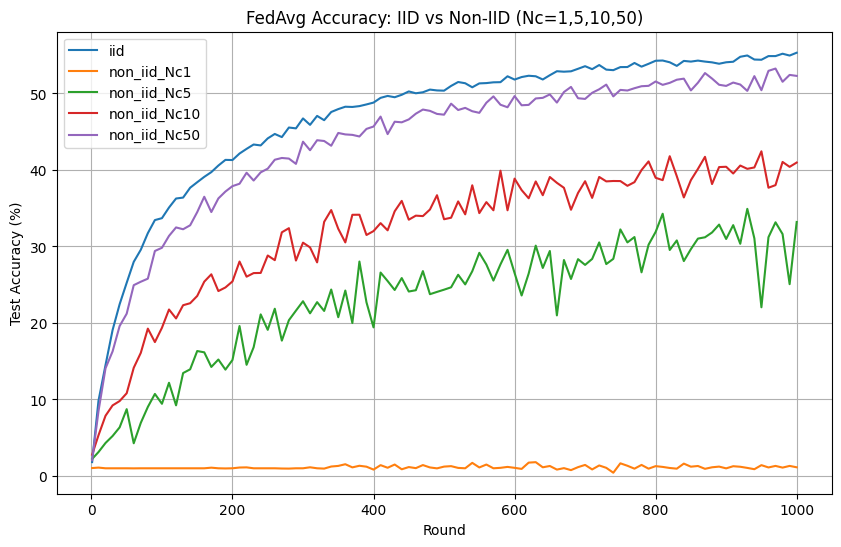

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import copy
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# If you have a separate dataset_sharder.py, import it here:
# from dataset_sharder import DatasetSharder


class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



class FedAvg:
    def __init__(self, config, model, client_datasets, test_loader):
        self.config = config
        self.global_model = model
        self.client_datasets = client_datasets
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.num_clients = config['num_clients']

    def client_update(self, client_model, optimizer, train_loader):
        client_model.train()
        for epoch in range(self.config['local_epochs']):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = client_model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return client_model.state_dict()

    def aggregate(self, client_weights):
        global_weights = copy.deepcopy(client_weights[0])
        for key in global_weights.keys():
            for i in range(1, len(client_weights)):
                global_weights[key] += client_weights[i][key]
            global_weights[key] = torch.div(global_weights[key], len(client_weights))
        return global_weights

    def test(self):
        """Returns only test accuracy (no test loss is tracked)."""
        self.global_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100.0 * correct / total
        return accuracy  # Not returning loss anymore

    def run(self):
        """Trains for config['rounds'], returning only accuracies + rounds_list."""
        num_selected = max(1, int(self.config['client_fraction'] * self.num_clients))
        test_accuracies = []
        rounds_list = []

        for round_ in tqdm(range(self.config['rounds']), desc="Federated Training Rounds"):
            # 1) Randomly select a subset of clients
            selected_clients = random.sample(range(self.num_clients), num_selected)
            client_weights = []

            # 2) Each selected client trains locally
            for client_idx in selected_clients:
                local_model = copy.deepcopy(self.global_model)
                local_model.to(self.device)
                optimizer = optim.SGD(local_model.parameters(),
                                      lr=self.config['lr'],
                                      momentum=0.9,
                                      weight_decay=0.0004)

                client_dataset = self.client_datasets[client_idx]
                train_loader = DataLoader(
                    client_dataset,
                    batch_size=self.config['batch_size'],
                    shuffle=True
                )

                local_weights = self.client_update(local_model, optimizer, train_loader)
                client_weights.append(local_weights)

            # 3) Aggregate local updates => new global model
            global_weights = self.aggregate(client_weights)
            self.global_model.load_state_dict(global_weights)

            # 4) Evaluate every 'test_freq' rounds (or round 0)
            if (round_ + 1) % self.config['test_freq'] == 0 or round_ == 0:
                accuracy = self.test()
                test_accuracies.append(accuracy)
                rounds_list.append(round_ + 1)
                print(f"Round {round_+1} => Test Accuracy: {accuracy:.2f}%")

        return test_accuracies, rounds_list


def main():
    # Hyperparameters
    K = 100
    C = 0.1
    N = 1000  # total rounds
    J = 4   # local epochs
    lr = 0.01
    B = 64
    test_freq = 10

    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CIFAR-100
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(root='./data', train=True,
                                 download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=transform_test)
    test_loader = DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)



    # Example non-IID scenario (n_labels=5) plus IID scenario:
    scenarios = [
        ('iid', None),
        ('non_iid', 1),
        ('non_iid', 5),
        ('non_iid', 10),
        ('non_iid', 50)
    ]

    def run_fedavg(shard_type, n_labels=5):
        # Build the client datasets
        sharder = DatasetSharder(trainset, K=K, shard_type=shard_type, n_labels=n_labels)
        client_datasets = sharder.shard_dataset()

        # FedAvg config
        fed_config = {
            'num_clients': K,
            'client_fraction': C,
            'rounds': N,
            'local_epochs': J,
            'lr': lr,
            'batch_size': B,
            'test_freq': test_freq
        }

        global_model = EnhancedLeNet().to(device)
        fedavg = FedAvg(fed_config, global_model, client_datasets, test_loader)

        scenario_name = shard_type if shard_type == 'iid' else f"non_iid_{n_labels}"
        print(f"\n--- Shard config: {scenario_name} ---")
        test_accs, rounds_list = fedavg.run()
        return test_accs, rounds_list

    # Collect results
    all_accuracies = {}
    all_rounds = {}

    for (typ, nl) in scenarios:
        scenario_key = typ if typ == 'iid' else f"non_iid_Nc{nl}"
        if typ == 'iid':
            test_accs, rounds_list = run_fedavg('iid')
        else:
            test_accs, rounds_list = run_fedavg('non_iid', n_labels=nl)

        all_accuracies[scenario_key] = test_accs
        all_rounds[scenario_key] = rounds_list

    # Plot in high quality
    plt.figure(figsize=(10, 6))  # bigger figure
    for scenario_name in all_accuracies:
        plt.plot(all_rounds[scenario_name], all_accuracies[scenario_name], label=scenario_name)

    plt.title("FedAvg Accuracy: IID vs Non-IID (Nc=1,5,10,50)")
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Use high DPI for clearer image in LaTeX
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fname = f"comparison_{timestamp}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to {fname}")
    plt.show()


if __name__ == "__main__":
    main()
